In [339]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [296]:
data=pd.read_csv("client.csv")
df=pd.read_csv("toxicity.csv")

In [268]:
data

,user_id,first_day,latest_day,lifespan,client,membership_type,joined_at_least_1_hub
0,594132bd-7b3e-4ec4-b752-06ee1711d297,2017-10-11,2017-10-11,0,new_client,free,NaN
1,533f08c8-e1ee-4925-96d9-9aeeba55b5ba,2017-10-11,2017-10-11,0,new_client,free,NaN
2,0840ad75-5337-4193-8cf8-0348b126e697,2017-10-11,2017-10-11,0,web_client,free,NaN
3,6e51c17f-4a81-4bb9-9f35-f0e2839da86e,2017-10-11,2017-10-11,0,new_client,free,True
4,f0dde747-b394-4a75-a74f-5e4adec18a28,2017-10-11,2017-10-11,0,new_client,free,NaN
...,...,...,...,...,...,...,...
3300,3600a108-93e1-4f25-8d14-d8c514ab39fb,2018-01-11,2018-01-11,0,new_client,free,True
3301,9a6085be-fd21-449d-a6e6-e55fb563a7ef,2018-01-11,2018-01-11,0,web_client,free,True
3302,48b058b2-720d-40c1-afd7-ce2f004a8b1a,2018-01-11,2018-01-11,0,new_client,free,True
3303,aa58b807-df4b-4488-872a-4f58dcf09bea,2018-01-11,2018-01-11,0,new_client,free,True


In [269]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
lifespan,3305.0,25.142209,30.514173,0.0,0.0,10.0,46.0,92.0


In [270]:
data.dtypes

user_id                  object
first_day                object
latest_day               object
lifespan                  int64
client                   object
membership_type          object
joined_at_least_1_hub    object
dtype: object

In [271]:
# Encoding
data['first_day']=pd.to_datetime(data.first_day)
data['latest_day']=pd.to_datetime(data.latest_day)
data['lifespan']=data['lifespan'].astype(int)
data['client']=pd.get_dummies(data.client)['new_client']
data[pd.get_dummies(data['membership_type']).columns]=pd.get_dummies(data['membership_type'])
data.drop(columns='membership_type',inplace=True)

In [272]:
# We have NaN on this column
data.joined_at_least_1_hub.value_counts()

True    2810
Name: joined_at_least_1_hub, dtype: int64

In [273]:
data.joined_at_least_1_hub.isna().sum()

495

In [274]:
# Filling incorrect and NaN values with false
data=data.fillna(False)

In [275]:
# Retention
data['total_day']=data['latest_day']-data['first_day']
data['total_day']=pd.to_timedelta(data['total_day'])
retention=data.groupby(['first_day','total_day']).count()[['latest_day']]
x=retention.reset_index().pivot_table(columns='total_day', index='first_day', values='latest_day')
x=x.T.cumsum().fillna(method='ffill')

In [276]:
x

first_day,2017-10-11,2017-10-12,2017-10-13,2017-10-14,2017-10-15,2017-10-16,2017-10-17,2017-10-18,2017-10-19,2017-10-20,...,2018-01-02,2018-01-03,2018-01-04,2018-01-05,2018-01-06,2018-01-07,2018-01-08,2018-01-09,2018-01-10,2018-01-11
total_day,,,,,,,,,,,,,,,,,,,,,
0 days,28.0,19.0,33.0,43.0,29.0,12.0,13.0,17.0,23.0,16.0,...,9.0,10.0,8.0,12.0,22.0,20.0,14.0,9.0,16.0,17.0
1 days,29.0,25.0,45.0,50.0,30.0,14.0,15.0,22.0,24.0,19.0,...,10.0,14.0,13.0,15.0,27.0,21.0,16.0,14.0,27.0,17.0
2 days,36.0,26.0,47.0,51.0,30.0,16.0,15.0,25.0,26.0,21.0,...,12.0,17.0,16.0,17.0,29.0,22.0,18.0,16.0,27.0,17.0
3 days,40.0,31.0,47.0,51.0,31.0,16.0,15.0,25.0,26.0,23.0,...,13.0,20.0,16.0,20.0,32.0,23.0,23.0,16.0,27.0,17.0
4 days,43.0,35.0,49.0,51.0,31.0,16.0,17.0,26.0,27.0,25.0,...,16.0,21.0,16.0,23.0,35.0,30.0,23.0,16.0,27.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88 days,276.0,124.0,176.0,152.0,106.0,54.0,58.0,56.0,71.0,60.0,...,30.0,32.0,22.0,32.0,42.0,30.0,23.0,16.0,27.0,17.0
89 days,291.0,127.0,183.0,159.0,106.0,54.0,58.0,56.0,71.0,60.0,...,30.0,32.0,22.0,32.0,42.0,30.0,23.0,16.0,27.0,17.0
90 days,305.0,131.0,198.0,159.0,106.0,54.0,58.0,56.0,71.0,60.0,...,30.0,32.0,22.0,32.0,42.0,30.0,23.0,16.0,27.0,17.0


In [277]:
last=pd.DataFrame(((x.max()-x)/x.max()*100).T.mean()[:20])

In [278]:
last

,0
total_day,
0 days,64.860588
1 days,58.825370
2 days,55.552584
3 days,52.823532
4 days,50.547647
5 days,48.615592
6 days,46.344451
7 days,44.737790
8 days,43.229245


In [279]:
data['retention']=(data['first_day']-data['latest_day']).dt.days
retention=data.groupby('retention').count()[['user_id']].reset_index()
retention['retention']=abs(retention['retention'])
retention=retention.sort_values('retention')

In [280]:
fig = px.bar(retention, x='retention', y='user_id')
fig.show()

In [281]:
retention['user_id']=(retention['user_id']/3305)*100

In [282]:
fig = px.bar(retention, x='retention', y='user_id')
fig.show()

In [283]:
fig = px.pie(retention, values='user_id', names='retention')
fig.update_traces(textposition='inside', textinfo='percent+label')

In [297]:
# Toxicity
df

,row,flirtation,identity_attack,insult,severe_toxicity,sexually_explicit,threat,label
0,0,0.593828,0.563516,0.849090,0.864632,0.777347,0.602494,Offensive
1,1,0.213193,0.407253,0.925010,0.856451,0.456983,0.592931,Offensive
2,2,0.474532,0.323574,0.710831,0.747318,0.933715,0.208848,Very offensive
3,3,0.503426,0.407557,0.796685,0.854638,0.955973,0.343336,Neutral
4,4,0.394807,0.170078,0.561849,0.766563,0.459300,0.223698,Profanity
...,...,...,...,...,...,...,...,...
11995,11995,0.543366,0.684481,0.951176,0.945009,0.878651,0.765876,Offensive
11996,11996,0.843702,0.877267,0.933437,0.945656,0.980018,0.476850,Very offensive
11997,11997,0.372335,0.979884,0.963483,0.945009,0.685437,0.308390,Very offensive
11998,11998,0.747068,0.906385,0.953521,0.945589,0.987091,0.926245,Very offensive


In [298]:
dummy=pd.get_dummies(df['label'])
dummy['row']=df['row']
df=df.merge(dummy,on='row', how='left')
df=df.drop(columns=['row'])

In [306]:
df

,flirtation,identity_attack,insult,severe_toxicity,sexually_explicit,threat,Extremely offensive,Hate speech,Neutral,Offensive,Profanity,Unknown,Very offensive
0,0.593828,0.563516,0.849090,0.864632,0.777347,0.602494,0,0,0,1,0,0,0
1,0.213193,0.407253,0.925010,0.856451,0.456983,0.592931,0,0,0,1,0,0,0
2,0.474532,0.323574,0.710831,0.747318,0.933715,0.208848,0,0,0,0,0,0,1
3,0.503426,0.407557,0.796685,0.854638,0.955973,0.343336,0,0,1,0,0,0,0
4,0.394807,0.170078,0.561849,0.766563,0.459300,0.223698,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.543366,0.684481,0.951176,0.945009,0.878651,0.765876,0,0,0,1,0,0,0
11996,0.843702,0.877267,0.933437,0.945656,0.980018,0.476850,0,0,0,0,0,0,1
11997,0.372335,0.979884,0.963483,0.945009,0.685437,0.308390,0,0,0,0,0,0,1
11998,0.747068,0.906385,0.953521,0.945589,0.987091,0.926245,0,0,0,0,0,0,1


In [303]:
dummy

,Extremely offensive,Hate speech,Neutral,Offensive,Profanity,Unknown,Very offensive,row
0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,1
2,0,0,0,0,0,0,1,2
3,0,0,1,0,0,0,0,3
4,0,0,0,0,1,0,0,4
...,...,...,...,...,...,...,...,...
11995,0,0,0,1,0,0,0,11995
11996,0,0,0,0,0,0,1,11996
11997,0,0,0,0,0,0,1,11997
11998,0,0,0,0,0,0,1,11998


In [301]:
df.label.value_counts()

Offensive              5966
Profanity              3430
Very offensive         1138
Neutral                 814
Extremely offensive     426
Unknown                 140
Hate speech              86
Name: label, dtype: int64

In [302]:
corr=df.corr()
fig = px.imshow(corr, text_auto=True, aspect="auto")
fig.show()

C:\Users\ozan-\AppData\Local\Temp\ipykernel_15972\3844041992.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



In [304]:
df=df.drop(columns='label')

In [305]:
df

,flirtation,identity_attack,insult,severe_toxicity,sexually_explicit,threat,Extremely offensive,Hate speech,Neutral,Offensive,Profanity,Unknown,Very offensive
0,0.593828,0.563516,0.849090,0.864632,0.777347,0.602494,0,0,0,1,0,0,0
1,0.213193,0.407253,0.925010,0.856451,0.456983,0.592931,0,0,0,1,0,0,0
2,0.474532,0.323574,0.710831,0.747318,0.933715,0.208848,0,0,0,0,0,0,1
3,0.503426,0.407557,0.796685,0.854638,0.955973,0.343336,0,0,1,0,0,0,0
4,0.394807,0.170078,0.561849,0.766563,0.459300,0.223698,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.543366,0.684481,0.951176,0.945009,0.878651,0.765876,0,0,0,1,0,0,0
11996,0.843702,0.877267,0.933437,0.945656,0.980018,0.476850,0,0,0,0,0,0,1
11997,0.372335,0.979884,0.963483,0.945009,0.685437,0.308390,0,0,0,0,0,0,1
11998,0.747068,0.906385,0.953521,0.945589,0.987091,0.926245,0,0,0,0,0,0,1


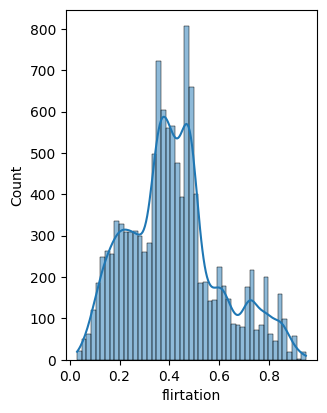

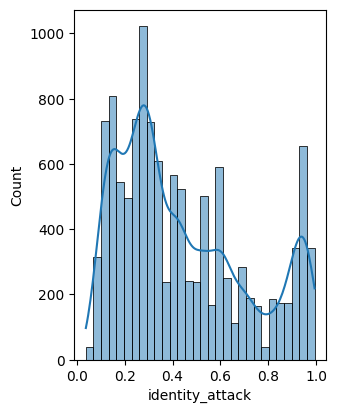

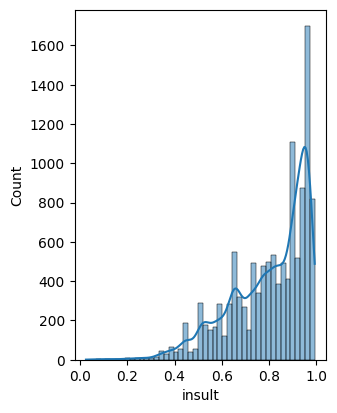

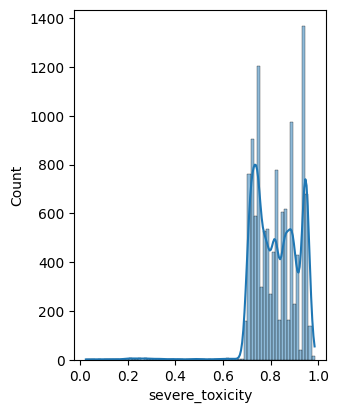

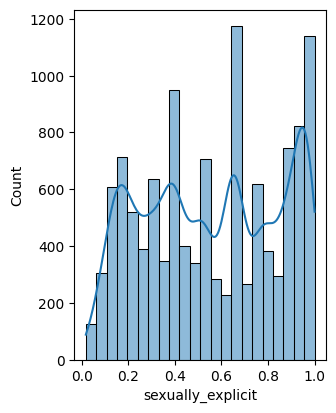

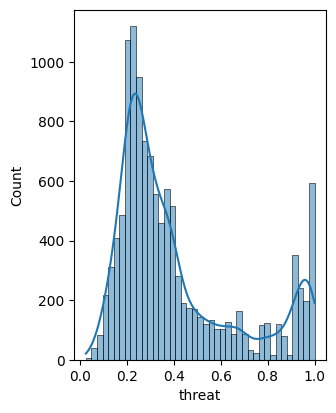

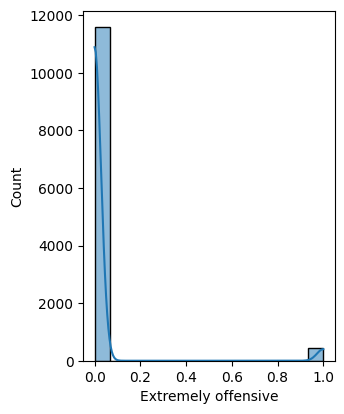

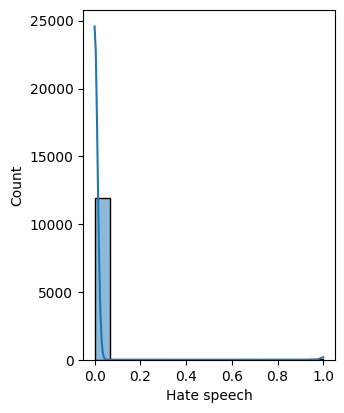

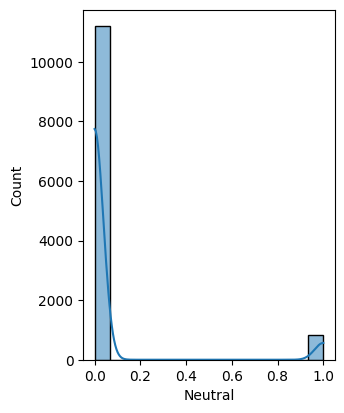

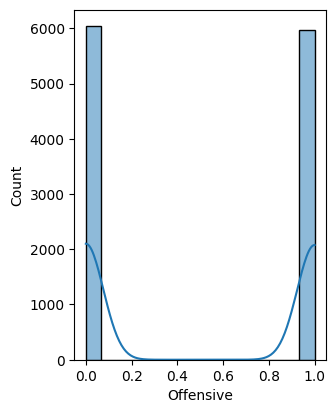

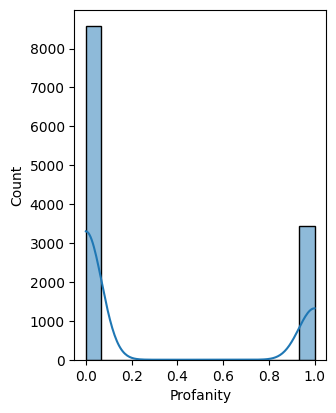

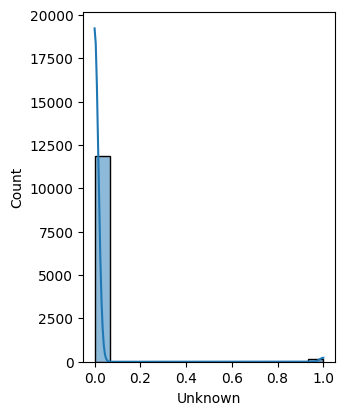

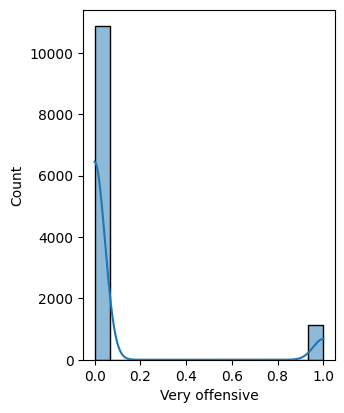

In [313]:
number_of_columns = 13
number_of_rows =  1
l = df.columns.values
for i in range(0,len(l)):
    plt.figure(figsize=(50,10))
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.histplot(df[l[i]],kde=True)
    plt.show()

In [324]:
# Model
forest = RandomForestClassifier(random_state=1)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=2)
train=df[['flirtation', 'identity_attack', 'insult', 'severe_toxicity','sexually_explicit', 'threat']]
test=df[['Extremely offensive', 'Hate speech',
       'Neutral', 'Offensive', 'Profanity', 'Unknown', 'Very offensive']]
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.33, random_state=42)
multi_target_forest.fit(X_train, y_train)
result=multi_target_forest.predict(X_test)
accuracy_score(y_test, result, normalize=True)

0.5818181818181818

In [326]:
# Grid Search
# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 2)]
# max_features = ['sqrt']
# max_depth = [int(x) for x in np.linspace(10, 100, num = 2)]
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 5]
# bootstrap = [True, False]
# random_grid = {'n_estimators': n_estimators,
               # 'max_features': max_features,
               # 'max_depth': max_depth,
               # 'min_samples_split': min_samples_split,
               # 'min_samples_leaf': min_samples_leaf,
               # 'bootstrap': bootstrap}
# print(random_grid)
# rf = RandomForestClassifier()

# grid_search = GridSearchCV(estimator = rf, param_grid = random_grid, 
                          # cv = 2, n_jobs = 4, verbose = 2)
# grid_search.fit(X_train, y_train)

In [342]:
accuracy_score(y_test, result, normalize=True)

0.5818181818181818

In [349]:
f1_score(y_test, result,average='weighted')

0.6313660731095341

In [344]:
print(classification_report(result, y_test))

              precision    recall  f1-score   support

           0       0.48      0.72      0.58       102
           1       0.00      0.00      0.00         0
           2       0.45      0.76      0.56       174
           3       0.72      0.72      0.72      1978
           4       0.56      0.69      0.62       902
           5       0.40      0.64      0.49        28
           6       0.24      0.58      0.34       150

   micro avg       0.59      0.70      0.64      3334
   macro avg       0.41      0.59      0.47      3334
weighted avg       0.63      0.70      0.66      3334
 samples avg       0.59      0.59      0.59      3334



c:\Users\ozan-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\ozan-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.

